<a href="https://colab.research.google.com/github/S-Deshmukh46/Appliances_Energy_Prediction/blob/main/Capstone_Appliances_Energy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions
were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the
temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for
10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters.
Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded
from a public data set from Reliable Prognosis (rp5.ru) and merged together with the
experimental data sets using the date and time column. Two random variables have been
included in the data set for testing the regression models and to filter out non-predictive attributes
(parameters).**



Data Description
date time year-month-day hour:minute:second

date - time year-month-day hour:minute:second

Appliances - energy use in Wh (Dependent variable)

lights - energy use of light fixtures in the house in Wh (Drop this column)

T1 - Temperature in kitchen area, in Celsius

RH1 - Humidity in kitchen area, in %

T2 - Temperature in living room area, in Celsius

RH2 - Humidity in living room area, in %

T3 - Temperature in laundry room area

RH3 - Humidity in laundry room area, in %

T4 - Temperature in office room, in Celsius

RH4 - Humidity in office room, in %

T5 - Temperature in bathroom, in Celsius

RH5 - Humidity in bathroom, in %

T6 - Temperature outside the building (north side), in Celsius

RH6 - Humidity outside the building (north side), in %

T7 - Temperature in ironing room, in Celsius

RH7 - Humidity in ironing room, in %

T8 - Temperature in teenager room 2, in Celsius

RH8 - Humidity in teenager room 2, in %

T9 - Temperature in parents room, in Celsius

RH9 - Humidity in parents room, in %

T_out - Temperature outside (from Chievres weather station), in Celsius

Pressure - (from Chievres weather station), in mm Hg RHout

Humidity - outside (from Chievres weather station), in %

Wind speed - (from Chievres weather station), in m/s

Visibility - (from Chievres weather station), in km

Tdewpoint - (from Chievres weather station), Â°C

rv1 - Random variable 1, nondimensional

rv2 - Random variable 2, nondimensional



**Where indicated, hourly data (then interpolated) from the nearest airport weather station(Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis,rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of weather data.**

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
from scipy import stats
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR
import time
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from tensorflow.keras import Sequential, layers, Input
import warnings
warnings.filterwarnings('ignore')

In [108]:
!pip install emath@git+git://github.com/whitead/emoji-math.git

  Cloning git://github.com/whitead/emoji-math.git to /tmp/pip-install-c0xve341/emath_cf4cffb5b1694626ac69c2abf75f2ca7
  Running command git clone -q git://github.com/whitead/emoji-math.git /tmp/pip-install-c0xve341/emath_cf4cffb5b1694626ac69c2abf75f2ca7
  fatal: remote error:
    The unauthenticated git protocol on port 9418 is no longer supported.
  Please see https://github.blog/2021-09-01-improving-git-protocol-security-github/ for more information.
ERROR: Could not find a version that satisfies the requirement emath (unavailable) (from versions: none)
ERROR: No matching distribution found for emath (unavailable)


## **Loading the data set using pandas**

In [109]:
# Loading csv file and creating a data frame 

appliances_energy_df=pd.read_csv('/content/drive/MyDrive/ALMA-BETTER/CAPSTONE PROJECTS/SUPERVISED ML-REGRESSION/APPLIANCES ENERGY PREDICTION/DATA & RESOURSES/Copy of data_application_energy.csv')

In [110]:
# Checking the data set's first 5 rows
appliances_energy_df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [111]:
# Checking the data set's last 5 rows
appliances_energy_df.tail()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,...,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,...,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,...,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,...,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,...,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [112]:
# Shape of the Data Set
print(f"The data frame have {appliances_energy_df.shape[0]} rows and {appliances_energy_df.shape[1]} columns.")

The data frame have 19735 rows and 29 columns.


In [113]:
# Number of features and list of features
print(f"Total number of features in the data set are :",len(appliances_energy_df.columns))
print(list(appliances_energy_df.columns))

Total number of features in the data set are : 29
['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']


In [114]:
# Information about data frame

appliances_energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [115]:
# Statistical description of features
appliances_energy_df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


***The feature "Appliances" represnt the energy consumption in Wh.The watt-hour (symbolized Wh) is a unit of energy equivalent to one watt (1 W) of power expended for one hour (1 h) of time.
For the better interpretation,changing feature name to "Consumption".***

***Features lights,rv1, and rv2 are not useful so will drop these features from the data set.***

In [116]:
# Renaming column
appliances_energy_df.rename(columns={'Appliances':'Consumption'},inplace=True)

# Dropping Unneccesary columns
appliances_energy_df.drop(['lights','rv1','rv2'],inplace=True,axis=1)

***The relaionship between the Humidity and Temperature is inversely proportional.
Relative humidity changes when temperatures change. Because warm air can hold more water vapor than cool air, relative humidity falls when the temperature rises if no moisture is added to the air.***

***Creating two columns for Average Humidity and Average Temperature.***

In [117]:
# Average Temperature
appliances_energy_df['Avg_Temp']=(appliances_energy_df.T1 + appliances_energy_df.T2 + appliances_energy_df.T3
                                  + appliances_energy_df.T4 + appliances_energy_df.T5 + appliances_energy_df.T7
                                 + appliances_energy_df.T8 + appliances_energy_df.T9 ) / 8

appliances_energy_df['Avg_Temp'].apply(lambda x: format(x,'.2f'))

0        18.43
1        18.44
2        18.42
3        18.40
4        18.41
         ...  
19730    24.87
19731    24.85
19732    24.82
19733    24.76
19734    24.74
Name: Avg_Temp, Length: 19735, dtype: object

In [118]:
# Average Humidity 
appliances_energy_df['Avg_Humidity']=(appliances_energy_df.RH_1 + appliances_energy_df.RH_2 + appliances_energy_df.RH_3
                                  + appliances_energy_df.RH_4 + appliances_energy_df.RH_5 + appliances_energy_df.RH_7
                                  + appliances_energy_df.RH_8 + appliances_energy_df.RH_9 ) / 8

appliances_energy_df['Avg_Humidity'].apply(lambda x: format(x,'.2f'))                            

0        46.74
1        46.67
2        46.56
3        46.47
4        46.46
         ...  
19730    46.14
19731    46.09
19732    46.24
19733    46.24
19734    46.19
Name: Avg_Humidity, Length: 19735, dtype: object

***Let's find out Null and Duplicates values if any......***

In [119]:
# Dulicate values 
appliances_energy_df.duplicated().sum()

0

In [120]:
# Null Values
appliances_energy_df.isna().sum()

date            0
Consumption     0
T1              0
RH_1            0
T2              0
RH_2            0
T3              0
RH_3            0
T4              0
RH_4            0
T5              0
RH_5            0
T6              0
RH_6            0
T7              0
RH_7            0
T8              0
RH_8            0
T9              0
RH_9            0
T_out           0
Press_mm_hg     0
RH_out          0
Windspeed       0
Visibility      0
Tdewpoint       0
Avg_Temp        0
Avg_Humidity    0
dtype: int64

**There are 0 rows with duplicate and Null values in data set.**

### **Exploring Dependable Variable**

In [121]:
appliances_energy_df['Consumption'].describe()

count    19735.000000
mean        97.694958
std        102.524891
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max       1080.000000
Name: Consumption, dtype: float64

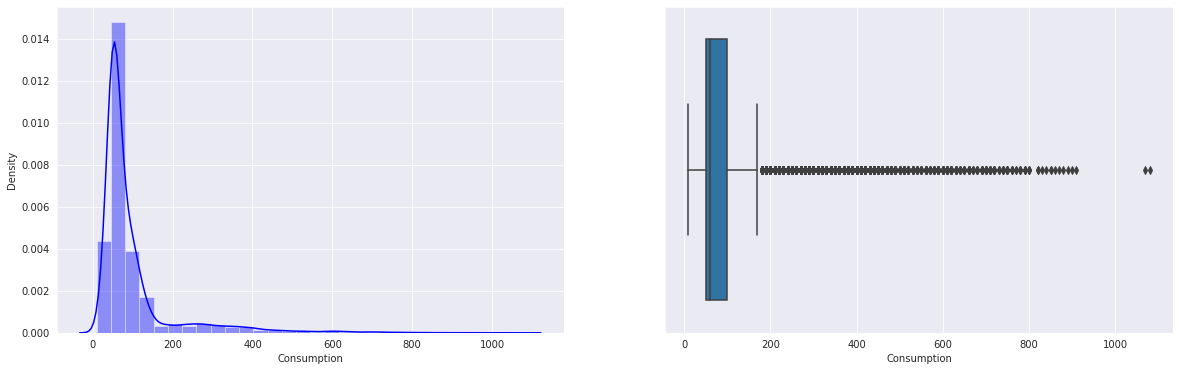

In [122]:
plt.figure(figsize=(20,6))
sns.set_style('darkgrid')

plt.subplot(1,2,1)
sns.distplot(appliances_energy_df.Consumption,bins=30,color='Blue')

plt.subplot(1,2,2)
sns.boxplot(appliances_energy_df.Consumption)

**Data for the dependable variable "Consumption" is not normally distributed since it is positively skewed..**

**About 75% of the values fall between 10 W/hr and 100 W/hr.**

**The data has a standard deviation of 102.54, which indicates there are lots of outliers.**

### **Exploraing Independent Variable**

In [123]:
# Creating a seperate data frames for all temperature varibales and all Humidity variables

# Temprature Data Frame
Temperature_df=appliances_energy_df[['T1','T2','T3','T4','T5','T6','T7','T8','T9','Avg_Temp','T_out' ]]

# Renaming column
Temperature_df.rename(columns={'T1':'kitchen_Temp','T2': 'living_room_Temp','T3':'laundry_room_temp',
                               'T4':'office_room_temp','T5':'bathroom_temp','T6':'outside_building_temp',
                               'T7':'ironing_room_temp','T8':'teenager_room_temp',
                               'T9':'parents_room_temp','T_out':'Chievres_weather_station'},inplace=True)

In [124]:
Temperature_df.describe()

,kitchen_Temp,living_room_Temp,laundry_room_temp,office_room_temp,bathroom_temp,outside_building_temp,ironing_room_temp,teenager_room_temp,parents_room_temp,Avg_Temp,Chievres_weather_station
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,20.341219,22.267611,20.855335,19.592106,7.910939,20.267106,22.029107,19.485828,20.815611,7.411665
std,1.606066,2.192974,2.006111,2.042884,1.844623,6.090347,2.109993,1.956162,2.014712,1.812567,5.317409
min,16.790000,16.100000,17.200000,15.100000,15.330000,-6.065000,15.390000,16.306667,14.890000,16.012708,-5.000000
25%,20.760000,18.790000,20.790000,19.530000,18.277500,3.626667,18.700000,20.790000,18.000000,19.663000,3.666667
50%,21.600000,20.000000,22.100000,20.666667,19.390000,7.300000,20.033333,22.100000,19.390000,20.597500,6.916667
75%,22.600000,21.500000,23.290000,22.100000,20.619643,11.256000,21.600000,23.390000,20.600000,21.764375,10.408333
max,26.260000,29.856667,29.236000,26.200000,25.795000,28.290000,26.000000,27.230000,24.500000,26.061940,26.100000


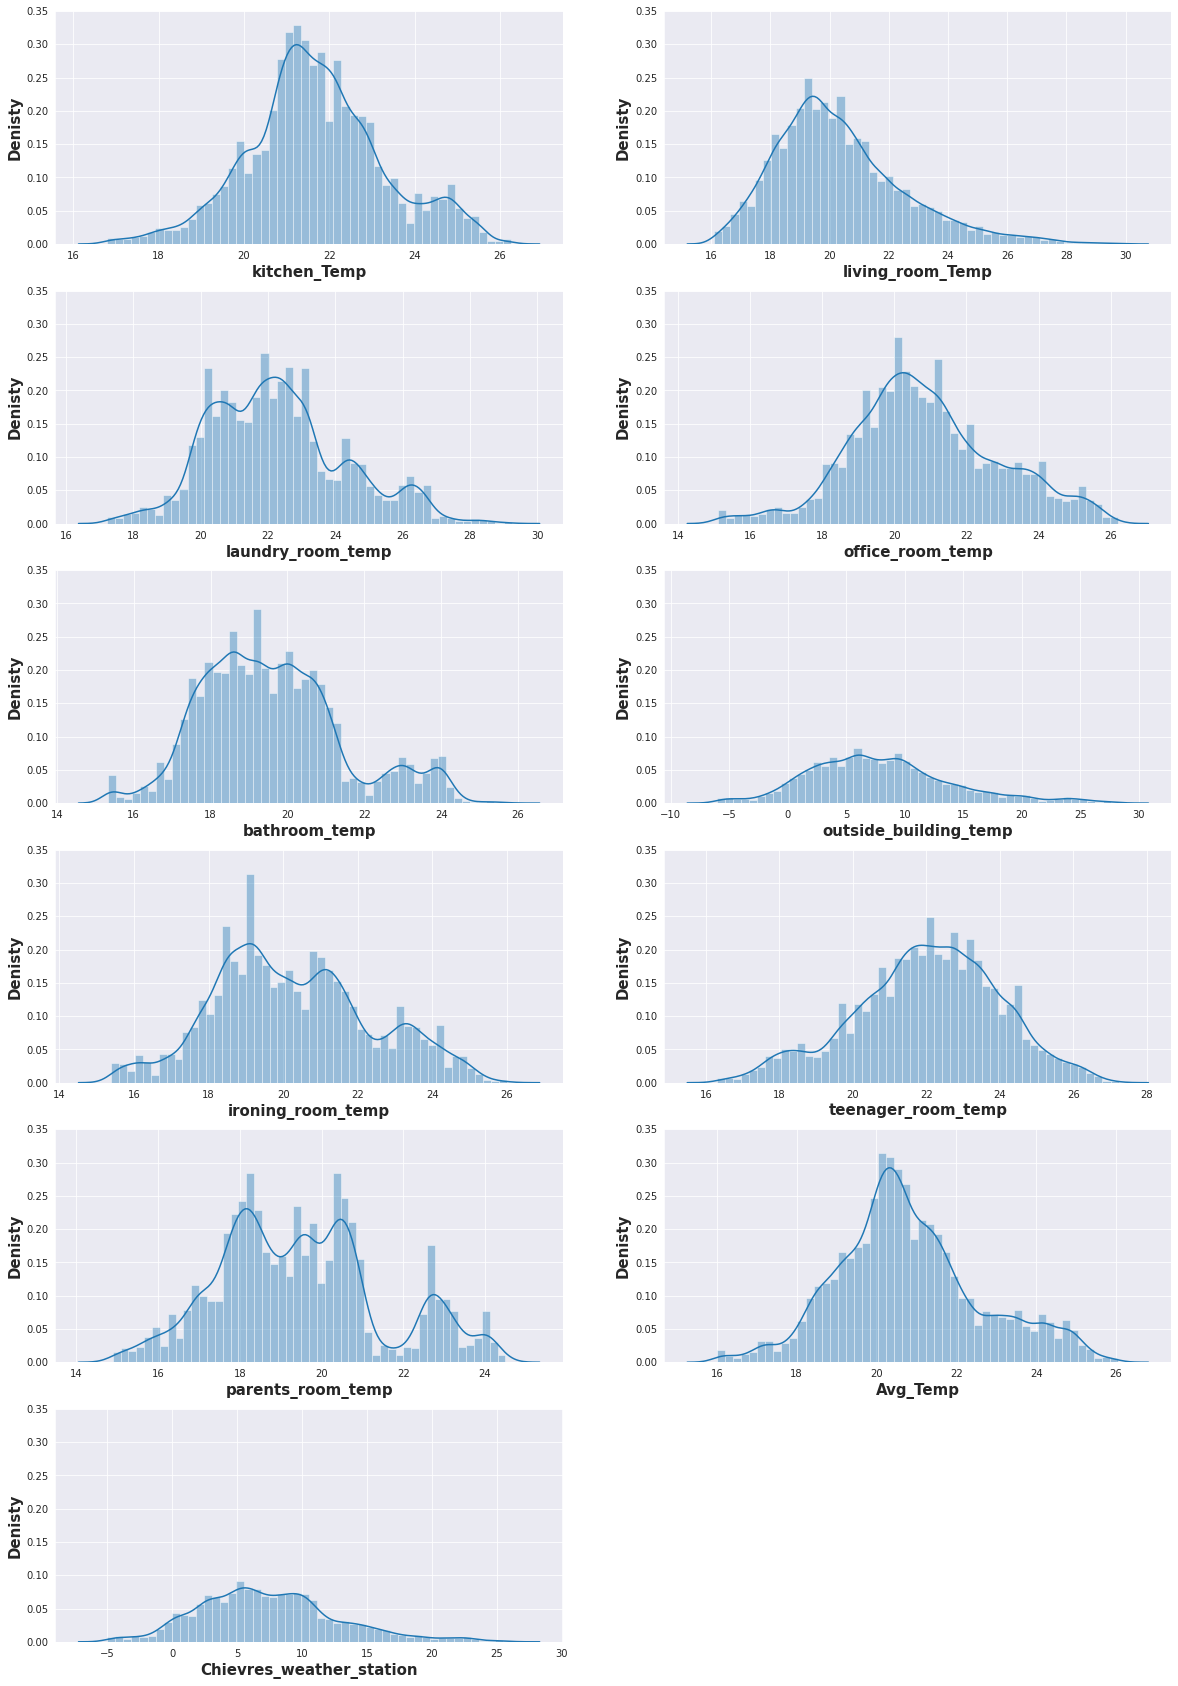

In [125]:
# Let's create subplot of histogram for all temperature values

Feature=Temperature_df.columns.to_list()  # Lsit of all temperature variables

axes=[]  # For axis
a=0      # No of rows

# Range for subplots 

while a < 6 :
  for i in range(2):  # No. of column
    axes.append((a,i))
  a+=1

# Plot for Subplots
sns.set_style('darkgrid')
figure,axis=plt.subplots(6,2,figsize=(20,30))

plt.xlabel(Feature[i], fontsize=15,fontdict={"weight": "bold"})
plt.ylabel('Density', fontsize=15,fontdict={"weight": "bold"})

for i in range (11):
  ax1=sns.distplot(Temperature_df[Feature[i]],ax=axis[axes[i][0],axes[i][1]])
  ax1.set_xlabel(Feature[i],size=15,fontdict={"weight": "bold"})
  ax1.set(ylim=(0,0.35))
  ax1.set_ylabel('Denisty',size=15,fontdict={"weight": "bold"})

figure.delaxes(axis[5,1]) # Delete extra subplot


**Outside, the minimum temperature is -6.06°C, the maximum temperature is 28.29°C, and the average temperature is 7.91°C.**

**The average temperature inside is around 20.81°C, the parents' room has the lowest minimum temperature of 14.69°C, and the living room has the highest maximum temperature of 29.86°C, which shows that the difference between outside and inside is quite large. Inside a lot of radiator heaters are used to maintain the temperature inside each room.** 

In [126]:
# Humidity Data Frame
Humidity_df=appliances_energy_df[['RH_1','RH_2','RH_3','RH_4','RH_5','RH_6',
                                  'RH_7','RH_8','RH_9','Avg_Humidity','RH_out']]

# Renaming column
Humidity_df.rename(columns={'RH_1':'kitchen_hum','RH_2': 'living_room_hum','RH_3':'laundry_room_hum',
                            'RH_4':'office_room_hum','RH_5':'bathroom_hum','RH_6':'outside_building_hum',
                            'RH_7':'ironing_room_hum','RH_8':'teenager_room_hum',
                            'RH_9':'parents_room_hum','RH_out':'Chievres_weather_station'},inplace=True)

In [127]:
Humidity_df.describe()

,kitchen_hum,living_room_hum,laundry_room_hum,office_room_hum,bathroom_hum,outside_building_hum,ironing_room_hum,teenager_room_hum,parents_room_hum,Avg_Humidity,Chievres_weather_station
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,40.259739,40.420420,39.242500,39.026904,50.949283,54.609083,35.388200,42.936165,41.552401,41.221952,79.750418
std,3.979299,4.069813,3.254576,4.341321,9.022034,31.149806,5.114208,5.224361,4.151497,3.977196,14.901088
min,27.023333,20.463333,28.766667,27.660000,29.815000,1.000000,23.200000,29.600000,29.166667,30.842798,24.000000
25%,37.333333,37.900000,36.900000,35.530000,45.400000,30.025000,31.500000,39.066667,38.500000,38.354583,70.333333
50%,39.656667,40.500000,38.530000,38.400000,49.090000,55.290000,34.863333,42.375000,40.900000,40.572708,83.666667
75%,43.066667,43.260000,41.760000,42.156667,53.663333,83.226667,39.000000,46.536000,44.338095,44.162176,91.666667
max,63.360000,56.026667,50.163333,51.090000,96.321667,99.900000,51.400000,58.780000,53.326667,53.947153,100.000000


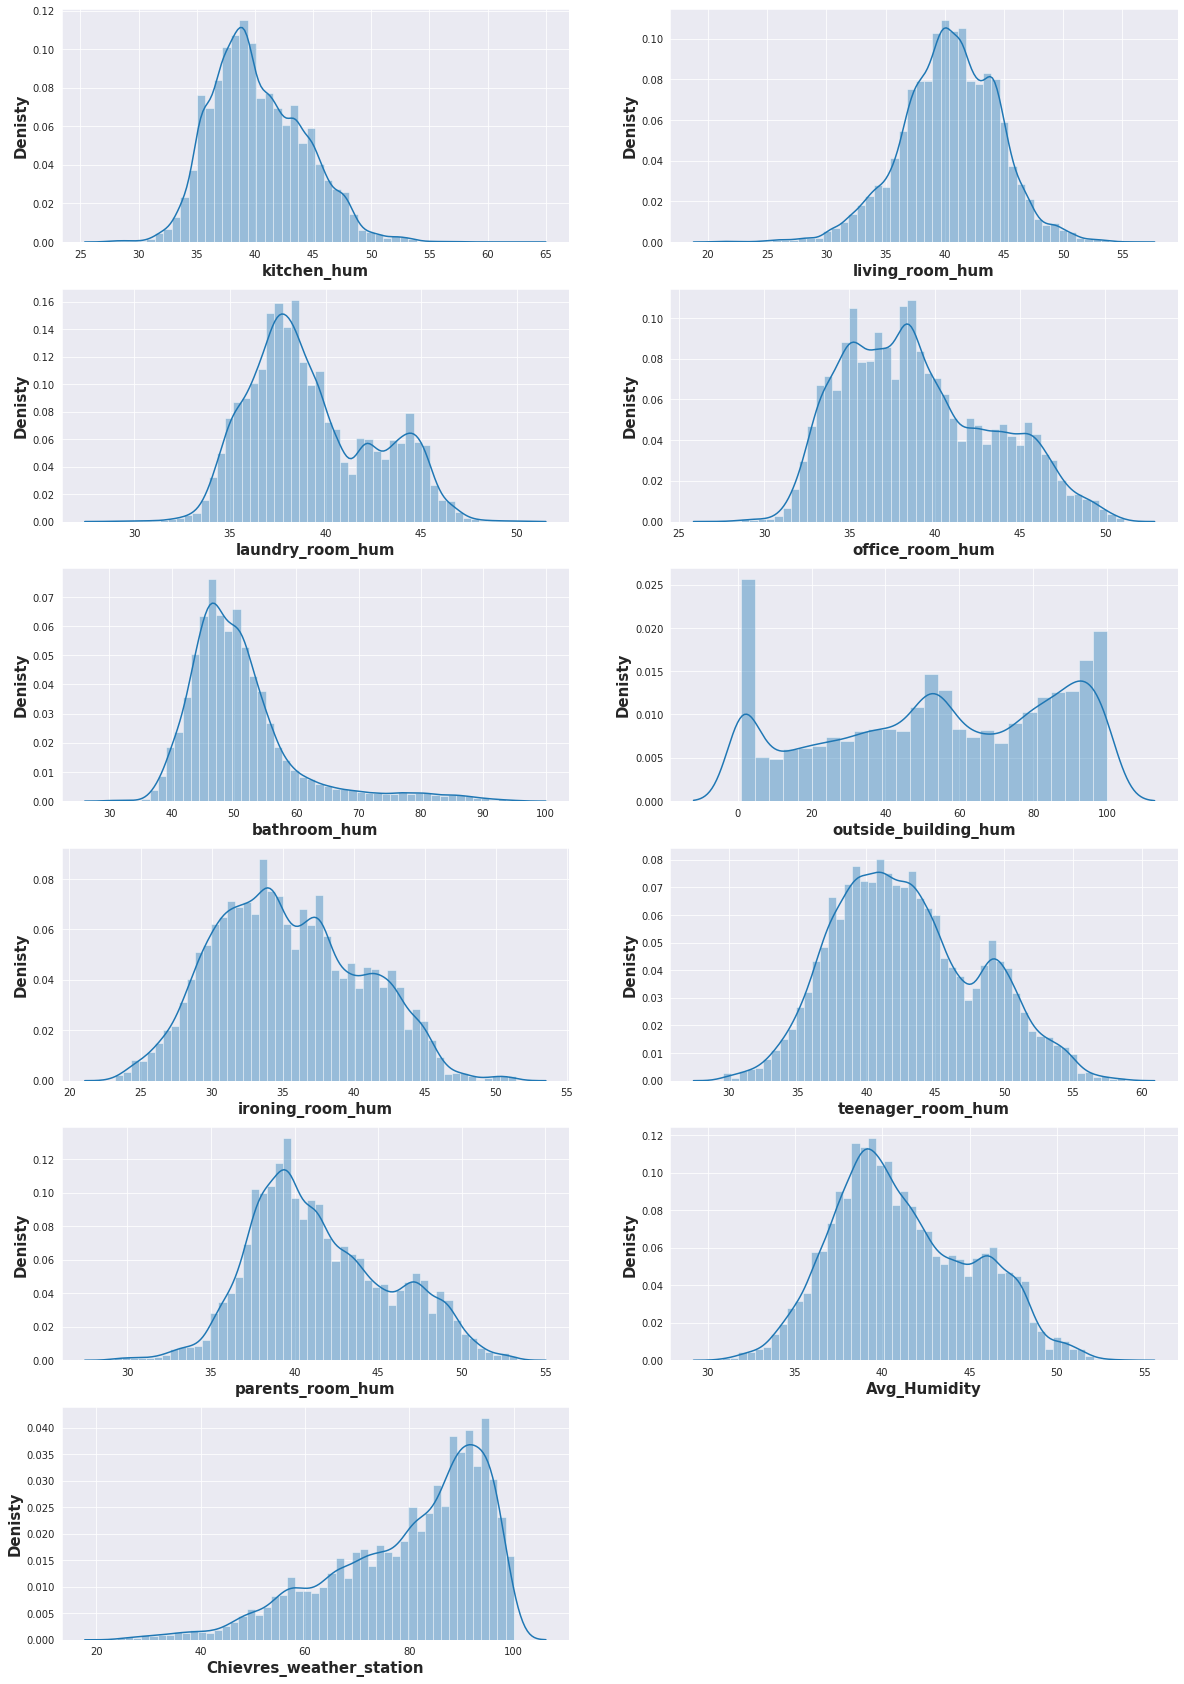

In [128]:
# Let's create subplot of histogram for all Humidity values

Feature=Humidity_df.columns.to_list()  # Lsit of all Humidity variables

axes=[]  # For axis
a=0      # No of rows

# Range for subplots 
while a < 6 :
  for i in range(2):  # No. of column
    axes.append((a,i))
  a+=1

# Plot for Subplots

figure,axis=plt.subplots(6,2,figsize=(20,30))

for i in range (11):
  ax1=sns.distplot(Humidity_df[Feature[i]],ax=axis[axes[i][0],axes[i][1]])
  ax1.set_xlabel(Feature[i],size=15,fontdict={"weight": "bold"})
  ax1.set_ylabel('Denisty',size=15,fontdict={"weight": "bold"})

figure.delaxes(axis[5,1])



**Ideally, a home should have a humidity level of about 45%. If it dips below 30%, it's much too dry, and if it's above 50%, the high humidity may start to feel uncomfortable.**

**The average humidity inside the house is 41.22% ,which is less than 45% and more than 30%.**

In [129]:
Chievres_weather_station_df=appliances_energy_df[['T_out','RH_out','Press_mm_hg','Tdewpoint','Visibility',
                                                  'Windspeed']]

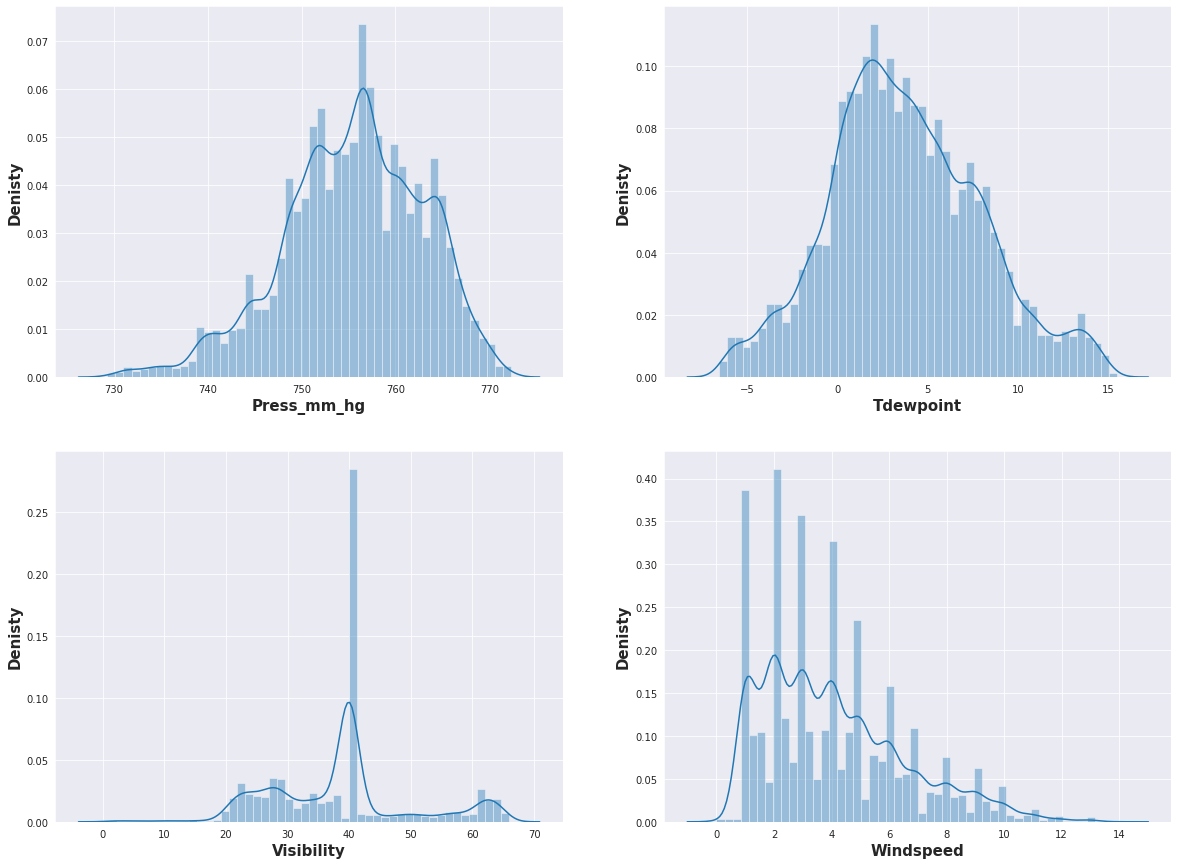

In [130]:
# Let's create subplot of distribution plot for data from Chievres weather station df

Feature=Chievres_weather_station_df.columns.to_list()[2:]  # List of Chievres weather station df variables

axes=[]  # For axis
a=0      # No of rows

# Range for subplots 

while a < 2 :
  for i in range(2):  # No. of column
    axes.append((a,i))
  a+=1

# Plot for Subplots
sns.set_style('darkgrid')
figure,axis=plt.subplots(2,2,figsize=(20,15))

plt.xlabel(Feature[i], fontsize=15,fontdict={"weight": "bold"})
plt.ylabel('Density', fontsize=15,fontdict={"weight": "bold"})

for i in range (4):
  ax1=sns.distplot(Chievres_weather_station_df[Feature[i]],ax=axis[axes[i][0],axes[i][1]])
  ax1.set_xlabel(Feature[i],size=15,fontdict={"weight": "bold"})
  ax1.set_ylabel('Denisty',size=15,fontdict={"weight": "bold"})

In [131]:
Chievres_weather_station_df.describe()

,T_out,RH_out,Press_mm_hg,Tdewpoint,Visibility,Windspeed
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,7.411665,79.750418,755.522602,3.760707,38.330834,4.039752
std,5.317409,14.901088,7.399441,4.194648,11.794719,2.451221
min,-5.000000,24.000000,729.300000,-6.600000,1.000000,0.000000
25%,3.666667,70.333333,750.933333,0.900000,29.000000,2.000000
50%,6.916667,83.666667,756.100000,3.433333,40.000000,3.666667
75%,10.408333,91.666667,760.933333,6.566667,40.000000,5.500000
max,26.100000,100.000000,772.300000,15.500000,66.000000,14.000000


**Pressure :- Atmospheric pressure is an indicator of weather. When a low-pressure system moves into an area, it usually leads to cloudiness, wind, and precipitation. High-pressure systems usually lead to fair, calm weather.**


> ***Average atmospheric pressure is 755.52 mm, which is ideal by any standards.***
---

**Dew point Temperature :- By defination the dew point is the temperature below which the water vapour in a volume of air at a constant pressure will condense into liquid water. It is the temperature at which the air is saturated with moisture.**



> ***The lower dew point temperature means air is dry and cold in the atmosphere,which is also indicated by the atmospheric temperatures.***
---

**Visibility :- Visibility is the distance you can see as determined by light and weather conditions. Weather conditions that affect visibility are fog, mist and smog.**



>***We can conclude that visibility is very good in the area since 75% of the data falls between 29km and 66km visibilty.***
---
**Windspeed :- There is mostly a light and gentle breeze in the area as 75% of the wind speed data falls within the 0 m/s to 5.5 m/s range.**





# **Realtionship Between The Energy Consumption & Variables.**

We have 4.5 months data and dates are in 'Date-Time' format.For computational purpose 

In [132]:
from datetime import datetime

In [133]:
appliances_energy_df['Date_Time']=appliances_energy_df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

In [134]:
appliances_energy_df.drop(['date'],inplace=True,axis=1)

In [135]:
appliances_energy_df['Date']=appliances_energy_df['Date_Time'].apply(lambda x: datetime.strftime(x,'%Y-%m-%d'))

In [136]:
appliances_energy_df['Month']=appliances_energy_df['Date_Time'].apply(lambda x:datetime.strftime(x,'%m'))

In [137]:
appliances_energy_df['Day']=appliances_energy_df['Date_Time'].apply(lambda x:datetime.strftime(x,'%A'))

In [138]:
appliances_energy_df['Day_Num']=appliances_energy_df['Date_Time'].apply(lambda x:datetime.strftime(x,'%w'))

In [139]:
appliances_energy_df['Hour']=appliances_energy_df['Date_Time'].apply(lambda x:datetime.strftime(x,'%H'))